### Практическое задание к уроку 3
Определите AUC_ROC и AUC_PR для модели логистической регрессии на тестовой выборке. Используйте реализацию модели в виде класса и функцию confusion, чтобы рассчитать TPR, FPR, precision, recal для различных порогов вероятности.  
Дополнительное задание(не обязательно): Получите такие же характеристики для линейной регрессии и сравните две модели.

In [2]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from regressions import linear_regression, logistic_regression
from scipy.stats import norm
from sklearn import datasets
from matplotlib.colors import ListedColormap

%matplotlib inline

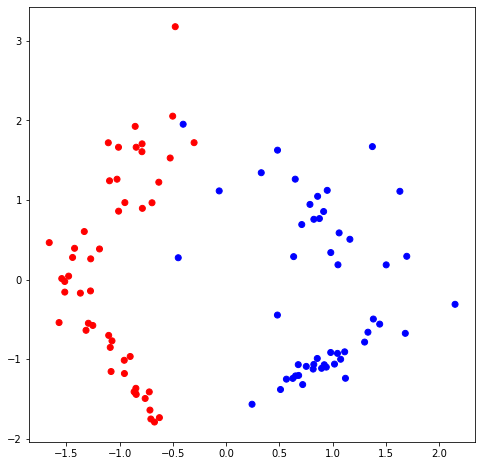

In [3]:
# сгеренируем данные с помощью sklearn.datasets
classes = datasets.make_classification(n_samples=100, n_features=2, n_informative=2,
                                       n_redundant=0, n_classes=2, random_state=1)
# datasets.make_blobs(centers = 2, cluster_std = 1.5, random_state=12)

# и изобразим их на графике
colors = ListedColormap(['red', 'blue'])

plt.figure(figsize=(8, 8))
plt.scatter([x[0] for x in classes[0]], [x[1] for x in classes[0]], c=classes[1], cmap=colors)

In [4]:
# перемешивание датасета
np.random.seed(12)
shuffle_index = np.random.permutation(classes[0].shape[0])
X_shuffled, y_shuffled = classes[0][shuffle_index], classes[1][shuffle_index]

# разбивка на обучающую и тестовую выборки
train_proportion = 0.7
train_test_cut = int(len(classes[0]) * train_proportion)

X_train, X_test, y_train, y_test = \
    X_shuffled[:train_test_cut], \
    X_shuffled[train_test_cut:], \
    y_shuffled[:train_test_cut], \
    y_shuffled[train_test_cut:]
    
print("Размер массива признаков обучающей выборки", X_train.shape)
print("Размер массива признаков тестовой выборки", X_test.shape)
print("Размер массива ответов для обучающей выборки", y_train.shape)
print("Размер массива ответов для тестовой выборки", y_test.shape)

Размер массива признаков обучающей выборки (70, 2)
Размер массива признаков тестовой выборки (30, 2)
Размер массива ответов для обучающей выборки (70,)
Размер массива ответов для тестовой выборки (30,)


In [5]:
mod=logistic_regression()
mod.fit(X_train, y_train)
y_predicted_test = mod.predict(X_test)
y_predicted_train = mod.predict(X_train)

# В качестве меры точности возьмем долю правильных ответов
train_accuracy = 100.0 - np.mean(np.abs(y_predicted_train - y_train)*100.0)
test_accuracy = 100.0 - np.mean(np.abs(y_predicted_test-y_test)*100.0)

print(f"Итоговый вектор весов w: {mod.w}")
print(f"Точность на обучающей выборке: {train_accuracy:.3f}")
print(f"Точность на тестовой выборке: {test_accuracy:.3f}")

Итоговый вектор весов w: [[0.32398168 0.01226158]]
Точность на обучающей выборке: 97.143
Точность на тестовой выборке: 96.667


In [6]:
proba = np.unique(mod.predict_proba(X_test))

In [40]:
proba

array([0.37576184, 0.37743532, 0.38605073, 0.39329824, 0.39603114,
       0.42197009, 0.42581106, 0.43518686, 0.43566684, 0.43744861,
       0.43928215, 0.46380207, 0.46916467, 0.47141598, 0.47900766,
       0.51300754, 0.53516296, 0.53568316, 0.54206801, 0.54703978,
       0.55547788, 0.5605486 , 0.56403656, 0.56439493, 0.56901128,
       0.57091569, 0.57432516, 0.57928111, 0.58140373, 0.59967655])

In [80]:
from numpy import trapz

class AUC_ROC_PR:
    
    def __init__(self, model):
        self.model = model
        
#     def confusion(self):
#         for i in self.proba:
            
    
    def _confusion(self, X, Y, proba):
        TP, FP = np.zeros(len(proba), dtype=int), np.zeros(len(proba), dtype=int)
        FN, TN = np.zeros(len(proba), dtype=int), np.zeros(len(proba), dtype=int)
        for i, p in enumerate(proba):
            predicted = self.model.predict(X, p)
            TP[i] = np.sum(np.logical_and(predicted == 1, Y == 1))
            FP[i] = np.sum(np.logical_and(predicted == 1, Y == 0))
            FN[i] = np.sum(np.logical_and(predicted == 0, Y == 1))
            TN[i] = np.sum(np.logical_and(predicted == 0, Y == 0))
        return TP, FP, FN, TN
    
    def _FPR_TPR(self, TP, FP, FN, TN):
#         assert TP == FP == FN == TN ''
        FPR = FP / (FP + TN)
        TPR = TP / (TP + FN)
        if FPR[0] > 0.5:
            FPR = np.flip(FPR)
        if TPR[0] > 0.5:
            TPR = np.flip(TPR)
        if FPR[0] != 0 or TPR[0] != 0:
            FPR = np.concatenate([[0], FPR])
            TPR = np.concatenate([[0], TPR])
        if FPR[-1] != 1 or TPR[-1] != 1:
            FPR = np.concatenate([FPR, [1.0]])
            TPR = np.concatenate([TPR, [1.0]])
        return FPR, TPR
    
    def AUC_ROC(self, X, Y, show_curve=False):
        proba = np.unique(self.model.predict_proba(X))
        TP, FP, FN, TN = self._confusion(X, Y, proba)
        FPR, TPR = self._FPR_TPR(TP, FP, FN, TN)
        
        
        if show_curve:
            plt.title('ROC curve')
            plt.ylim(0, 1.05)
            plt.xlabel('FPR')
            plt.ylabel('TPR')
            plt.grid()
            plt.legend(' ', title=f'AUC-ROC={self.AUC_ROC:.3f}', loc='lower right')
            plt.plot(FPR, TPR)

In [81]:
auc_mod = AUC_ROC_PR(mod)

In [52]:
a1, a2, a3, a4 = auc_mod._confusion(X_test, y_test, proba)

In [82]:
auc_mod._FPR_TPR(a1, a2, a3, a4)

(array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.07142857, 0.07142857, 0.14285714, 0.21428571,
        0.28571429, 0.35714286, 0.42857143, 0.5       , 0.57142857,
        0.64285714, 0.71428571, 0.78571429, 0.85714286, 0.92857143,
        1.        ]),
 array([0.    , 0.0625, 0.125 , 0.1875, 0.25  , 0.3125, 0.375 , 0.4375,
        0.5   , 0.5625, 0.625 , 0.6875, 0.75  , 0.8125, 0.875 , 0.9375,
        0.9375, 1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    ,
        1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    ]))

In [25]:
def confusion(predicted, actual):
    TP=np.sum(np.logical_and(predicted==1, actual==1))
    FP=np.sum(np.logical_and(predicted==1, actual==0))
    FN=np.sum(np.logical_and(predicted==0, actual==1))
    TN=np.sum(np.logical_and(predicted==0, actual==0))
    return {'TP': TP, 'FP': FP, 'FN': FN, 'TN': TN}

In [26]:
for p in proba:
    print(f"Для порога по вероятности {p} на тестовой выборке имеем: {confusion(mod.predict(X_test, p), y_test)}")

Для порога по вероятности 0.37576183889983183 на тестовой выборке имеем: {'TP': 16, 'FP': 13, 'FN': 0, 'TN': 1}
Для порога по вероятности 0.37743531819847453 на тестовой выборке имеем: {'TP': 16, 'FP': 12, 'FN': 0, 'TN': 2}
Для порога по вероятности 0.38605073396047773 на тестовой выборке имеем: {'TP': 16, 'FP': 11, 'FN': 0, 'TN': 3}
Для порога по вероятности 0.3932982404221594 на тестовой выборке имеем: {'TP': 16, 'FP': 10, 'FN': 0, 'TN': 4}
Для порога по вероятности 0.3960311448763592 на тестовой выборке имеем: {'TP': 16, 'FP': 9, 'FN': 0, 'TN': 5}
Для порога по вероятности 0.4219700922749085 на тестовой выборке имеем: {'TP': 16, 'FP': 8, 'FN': 0, 'TN': 6}
Для порога по вероятности 0.4258110607284189 на тестовой выборке имеем: {'TP': 16, 'FP': 7, 'FN': 0, 'TN': 7}
Для порога по вероятности 0.4351868598210908 на тестовой выборке имеем: {'TP': 16, 'FP': 6, 'FN': 0, 'TN': 8}
Для порога по вероятности 0.43566683838569675 на тестовой выборке имеем: {'TP': 16, 'FP': 5, 'FN': 0, 'TN': 9}
Дл